# Определение стоимости автомобилей

Сервис по продаже автомобилей разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm

## Подготовка данных

### Загрузка данных

In [2]:
try:
    df = pd.read_csv("autos.csv")
except:
    df = pd.read_csv("/datasets/autos.csv")

df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
55185,2016-03-05 16:44:01,100,small,1991,manual,0,fiesta,80000,3,NaN,ford,no,2016-03-05 00:00:00,0,30926,2016-03-06 04:45:01
243323,2016-03-09 17:45:31,890,small,1999,manual,75,fiesta,150000,9,petrol,ford,no,2016-03-09 00:00:00,0,79591,2016-04-07 09:16:31
183760,2016-04-02 15:43:47,850,wagon,1997,manual,116,vectra,150000,6,petrol,opel,no,2016-04-02 00:00:00,0,84562,2016-04-06 14:16:50
99455,2016-03-08 14:58:24,4200,bus,2002,manual,125,other,100000,10,petrol,honda,NaN,2016-03-08 00:00:00,0,42327,2016-04-05 22:16:44
79920,2016-03-08 17:49:55,1390,small,2004,manual,101,fiesta,150000,7,petrol,ford,no,2016-03-08 00:00:00,0,40699,2016-04-07 08:44:55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,NaN,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,NaN,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,NaN,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,NaN,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,NaN,1.000000


### Удаление ненужных признаков

В датасете имеются ненужные признаки: дата скачивания анкеты, количество фото, дата создания анкеты, почтовый индекс владельца, активность владельца

In [6]:
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
277430,3500,bus,2003,manual,136,touran,150000,9,gasoline,volkswagen,no
202746,6999,small,2009,manual,92,swift,30000,3,petrol,suzuki,NaN
351981,850,wagon,1997,manual,150,a4,150000,4,petrol,audi,no
31289,4250,sedan,1985,manual,81,other,150000,7,petrol,volvo,no
261459,250,small,1998,manual,0,ka,150000,7,petrol,ford,no


### Заполнение пропусков

В датасете имеются пропуски. Связаны они могут быть с тем, что ползователь анкеты решил не заполнять эти поля

In [7]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
dtype: int64

Пропуски в столбце Repared слабо связаны с другмим пропусками, к тому же их очень много. Скорее всего пропуск означает, что машина не была в ремонте

In [8]:
df['Repaired'] = df['Repaired'].fillna('no')

Пропуски в моделях невозможно восстановить, поэтому заполним значением 'Undefined'

In [9]:
df['Model'] = df['Model'].fillna('undefined')

Пропуски в других признаках:

In [10]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Заполним пропуски в типе машины значением other

In [11]:
df['VehicleType'] = df['VehicleType'].fillna('other')

In [12]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Заполним пропуски значением undefined

In [13]:
df['Gearbox'] = df['Gearbox'].fillna("undefined")

In [14]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Заполним пропуски значением other

In [15]:
df['FuelType'] = df['FuelType'].fillna('other')

In [16]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

### Обработка аномальных значений

Судя по desribe, аномальные значения присутсвуют в стообцах Price, RegistrationYear и Power

#### Price

<AxesSubplot:>

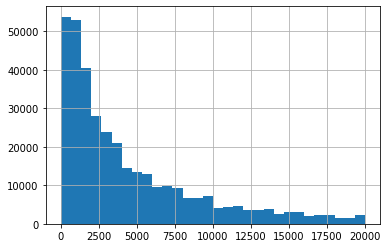

In [17]:
df['Price'].hist(bins=30)

<AxesSubplot:>

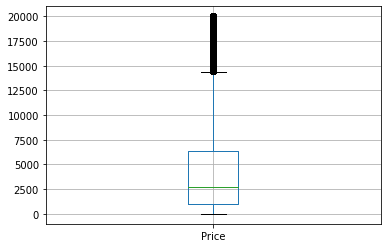

In [18]:
df.boxplot('Price')

Есть аномально дорогие автомобили, однако, вероятнее всего это автомобили бизнес класса

In [19]:
df[df['Price'] == 0]['Price'].count()

10772

In [20]:
df[(df['Price'] > 0) & (df['Price'] < 2)]['Price'].count()

1189

Некоторые атомабили стоят 0, есть те, что стоят от 0 до 2-х евро. Вероятнее всего это ошибка

<AxesSubplot:>

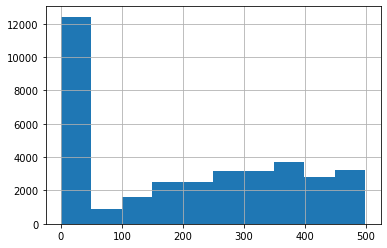

In [21]:
df[df['Price'] < 500]['Price'].hist()

Уберем значения ниже 100 евро

In [22]:
df = df[df['Price'] >= 100]

In [23]:
df.shape

(341055, 11)

#### Registration Year

<AxesSubplot:>

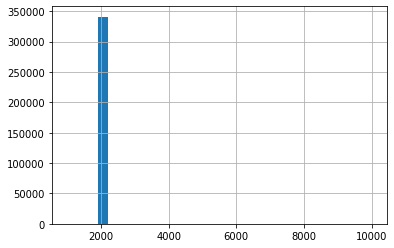

In [24]:
df['RegistrationYear'].hist(bins=30)

<AxesSubplot:>

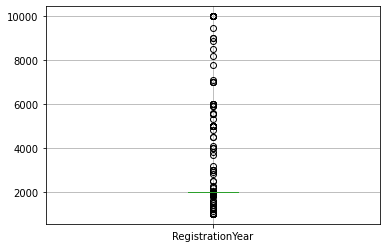

In [25]:
df.boxplot('RegistrationYear')

(1960.0, 2030.0)

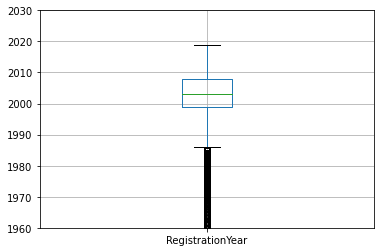

In [26]:
df.boxplot('RegistrationYear')
plt.ylim((1960, 2030))

Есть множество аномальных неадекватно высоких или низких значений.

In [27]:
df[df['RegistrationYear'] > 2023]['RegistrationYear'].count()

72

In [28]:
df[df['RegistrationYear'] < 1985]['RegistrationYear'].count()

4855

Рассматривать машины до 1985 года нет смысла, поэтому откинем все аномально высокие и ненужные года

<AxesSubplot:>

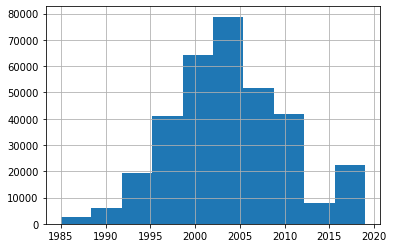

In [29]:
df = df[(df['RegistrationYear'] <= 2023) & (df['RegistrationYear'] >= 1985)]
df['RegistrationYear'].hist()

#### Power

<AxesSubplot:>

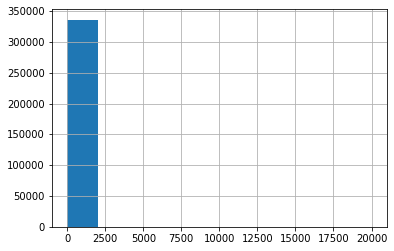

In [30]:
df['Power'].hist()

<AxesSubplot:>

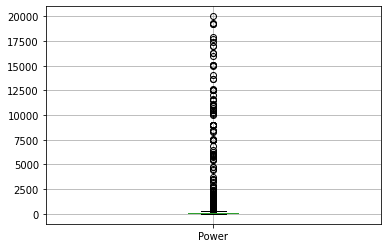

In [31]:
df.boxplot('Power')

(-100.0, 300.0)

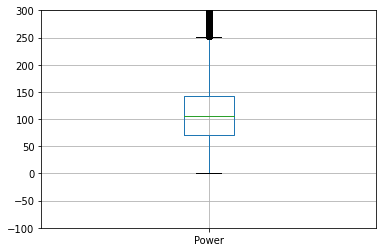

In [32]:
df.boxplot('Power')
plt.ylim((-100, 300))

In [33]:
df[df['Power'] == 0]['Power'].count()

33779

Удалим все значения выше 250 и значения равные 0

In [34]:
df = df[(df['Power'] <= 250) & (df['Power'] != 0)]

<AxesSubplot:>

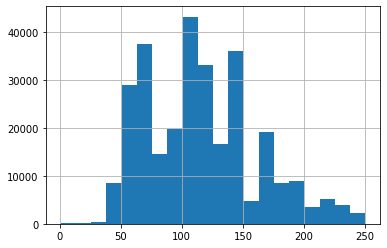

In [35]:
df['Power'].hist(bins=20)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295280 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              295280 non-null  int64 
 1   VehicleType        295280 non-null  object
 2   RegistrationYear   295280 non-null  int64 
 3   Gearbox            295280 non-null  object
 4   Power              295280 non-null  int64 
 5   Model              295280 non-null  object
 6   Kilometer          295280 non-null  int64 
 7   RegistrationMonth  295280 non-null  int64 
 8   FuelType           295280 non-null  object
 9   Brand              295280 non-null  object
 10  Repaired           295280 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


### Вывод раздела

Была проведена предобработка данных: данные загружены, удалены ненужные столбцы, заполнены пропуски, обработаны аномальные значения

## Обучение моделей

### Выделение категориальных признаков

Переведем категориальные признаки в тип int для обучения. LightGBM способен работать с категориальными признаками без OHE

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295280 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              295280 non-null  int64 
 1   VehicleType        295280 non-null  object
 2   RegistrationYear   295280 non-null  int64 
 3   Gearbox            295280 non-null  object
 4   Power              295280 non-null  int64 
 5   Model              295280 non-null  object
 6   Kilometer          295280 non-null  int64 
 7   RegistrationMonth  295280 non-null  int64 
 8   FuelType           295280 non-null  object
 9   Brand              295280 non-null  object
 10  Repaired           295280 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


In [38]:
df_categorical = df.copy()

In [39]:
df_categorical['VehicleType'] = df_categorical['VehicleType'].astype('category').cat.codes
df_categorical['Gearbox'] = df_categorical['Gearbox'].astype('category').cat.codes
df_categorical['Model'] = df_categorical['Model'].astype('category').cat.codes
df_categorical['FuelType'] = df_categorical['FuelType'].astype('category').cat.codes
df_categorical['Brand'] = df_categorical['Brand'].astype('category').cat.codes
df_categorical['Repaired'] = df_categorical['Repaired'].astype('category').cat.codes

In [40]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295280 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   Price              295280 non-null  int64
 1   VehicleType        295280 non-null  int8 
 2   RegistrationYear   295280 non-null  int64
 3   Gearbox            295280 non-null  int8 
 4   Power              295280 non-null  int64
 5   Model              295280 non-null  int16
 6   Kilometer          295280 non-null  int64
 7   RegistrationMonth  295280 non-null  int64
 8   FuelType           295280 non-null  int8 
 9   Brand              295280 non-null  int8 
 10  Repaired           295280 non-null  int8 
dtypes: int16(1), int64(5), int8(5)
memory usage: 15.5 MB


### Разделение на выборки

In [41]:
X, y = df_categorical.drop('Price', 1), df_categorical['Price']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [43]:
X_train.shape

(236224, 10)

In [44]:
X_test.shape

(59056, 10)

### Выбор модели

Создадим scorer с метрикой rmse

In [45]:
rmse = sklearn.metrics.make_scorer(lambda x, y: np.sqrt(mean_squared_error(x, y)), greater_is_better=False)

#### Dummy model

Для проверки на адекватность используем дамми модель

In [46]:
dummy_model = DummyRegressor()
dummy_model_score = cross_val_score(dummy_model, X_train, y_train, scoring=rmse)
np.mean(dummy_model_score)

-4444.406396776658

#### Decision Tree

In [47]:
%%time

tree_regressor = DecisionTreeRegressor(random_state=42)
tree_params = {'max_depth': range(1, 20)}
tree_model = GridSearchCV(tree_regressor, param_grid=tree_params, scoring=rmse).fit(X_train, y_train)

CPU times: user 41.5 s, sys: 36.3 ms, total: 41.5 s
Wall time: 41.7 s


In [48]:
tree_model.best_params_

{'max_depth': 13}

In [49]:
tree_model.best_score_

-1766.2187779185492

#### LightGBM

In [50]:
%%time

lightgbm_regressor = lightgbm.LGBMRegressor(random_state=42)
lightgbm_params = {'max_depth': range(10, 14), 'n_estimators': range(200, 401, 100)}
lightgbm_model = GridSearchCV(lightgbm_regressor, param_grid=lightgbm_params, scoring=rmse).fit(X_train, y_train)

CPU times: user 21min 1s, sys: 6.76 s, total: 21min 8s
Wall time: 21min 20s


In [51]:
lightgbm_model.best_params_

{'max_depth': 11, 'n_estimators': 400}

In [52]:
lightgbm_model.best_score_

-1484.3221095522704

### Выводы

Модель Lightgbm оказалась наилучшей (при ограниченом переборе гиперпараметров).

## Анализ моделей

Проверим время обучения и время предсказания моделей LightGBM и DecisionTree.

In [53]:
X_train.shape  # Размер обучающей выборки

(236224, 10)

In [54]:
X_test.shape # Размер тестовой выборки

(59056, 10)

### LightGBM

In [55]:
%%time 

lightgbm_model_best = lightgbm_model.best_estimator_.fit(X_train, y_train)

CPU times: user 1min 6s, sys: 308 ms, total: 1min 7s
Wall time: 1min 7s


In [56]:
%%time

lightgbm_predictions = lightgbm_model_best.predict(X_train)

CPU times: user 5.48 s, sys: 17.3 ms, total: 5.5 s
Wall time: 5.53 s


При тренировочной выборке размера порядка 240000 примеров, модель обучается примерно за 1 минуту. 

Время предсказания составляет 5.5 секунда.


### DecisionTree

In [57]:
%%time

tree_model_best = tree_model.best_estimator_.fit(X_train, y_train)

CPU times: user 630 ms, sys: 3.96 ms, total: 634 ms
Wall time: 649 ms


In [58]:
%%time

tree_predictions = tree_model_best.predict(X_train)

CPU times: user 39.7 ms, sys: 4 µs, total: 39.7 ms
Wall time: 43 ms


Скорость обучения и предсказания на несколько порядков ниже, 600 мс на обучение и 40 мс на предсказание.

### Итоги

In [61]:
pd.DataFrame(data=[[0.6, 0.04, 1766], [66.0, 5.5, 1484]],
             index=['DecisionTree', 'LightGBM'],
             columns=['Train Time', 'Prediction Time', 'RMSE Score'])

,Train Time,Prediction Time,RMSE Score
DecisionTree,0.6,0.04,1766
LightGBM,66.0,5.50,1484


## Тестирование лучшей модели

Лучшей оказалась модель LightGBM. Протестируем ее на тестовой выборке

In [60]:
np.sqrt(mean_squared_error(y_test, lightgbm_model_best.predict(X_test)))

1511.817455701587

Модель обладает необходимой точностью

## Выводы

Было выполнено:
 - Загрузка и предобработка данных:
  - Удалены ненужные столбцы
  - Заполнены пропуски
  - удалены аномальные значения
 - Был проведен подбор гиперпараметров для LightGBM и DecisionTree моделей, проведено сравнение с Dummy моделью
 - Была проведена проверка времени обучения и предсказания для двух моделей. LightGBM оказалась гораздо медленнее, однако качество rmse у модели лучше: 1550